# Lab3. Topic modeling

## Melnikov, Malysheva, Selivanovskaya

In [1]:
!pip install pyLDAvis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import pymorphy2
from scipy.sparse import *
import stop_words
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem.snowball import RussianStemmer
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm
import pyLDAvis
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models as gensimvis
import re
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Katya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Katya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\Katya\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps
C:\Users\Katya\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet

### Load prepocessed data and concatenate it

In [3]:
# Evgeny's data
df1 = pd.read_json("Preprocessed_data1.json")
df1

,article_id,title,category,tags,text
0,https://www.nn.ru/text/transport/2022/01/30/70...,Пятый мост через Оку начнут строить уже в этом...,transport,"[мост, новая транспортная сеть]",новый мост ока начать строить год контракт раз...
1,https://www.nn.ru/text/transport/2022/01/29/70...,«Решение о строительстве метро на площади Своб...,transport,"[метро, строительство метро в Нижнем Новгороде]",мку гуммид ответить урбанист настаивать строит...
2,https://www.nn.ru/text/transport/2022/01/26/70...,"Более 440 автомобилей, мешающих уборке снега, ...",transport,"[уборка снега, эвакуаторы]",автомобиль мешать уборка снег нижний новгород ...
3,https://www.nn.ru/text/gorod/2022/01/25/70399832/,Улицу Горького частично перекроют для строител...,transport,"[метро, строительство метро в Нижнем Новгороде]",март начаться первый перекрытие улица нижний н...
4,https://www.nn.ru/text/transport/2022/01/24/70...,"(Не) передавайте за проезд, пожалуйста: почти ...",transport,"[Нижний Новгород, валидатор, транспорт, общест...",общественный транспорт нижний новгород заработ...
...,...,...,...,...,...
3995,https://www.nn.ru/text/incidents/2020/06/13/69...,В лобовом ДТП под Балахной погиб ребенок,incidents,"[ДТП с погибшими, погиб ребенок]",плохой новость сегодня заканчиваться сожаление...
3996,https://www.nn.ru/text/incidents/2020/06/13/69...,Под Балахной лоб в лоб столкнулись два автомоб...,incidents,"[ДТП с погибшими, авария]",третий страшный дтп сегодняшний суть произойти...
3997,https://www.nn.ru/text/incidents/2020/06/13/69...,Красный Cadillac перевернулся на Гребном канал...,incidents,"[ДТП, авария, пьяное ДТП]",сегодня нижний новгород водитель cadillac отпр...
3998,https://www.nn.ru/text/incidents/2020/06/10/69...,"Из-за смертельной аварии, которую устроил актё...",incidents,"[ДТП, Михаил Ефремов]",полиция москва возбудить ещё один уголовный де...


In [4]:
# Katya's data
df2 = pd.read_json("Preprocessed_data2.json")
df2

,article_id,title,category,tags,text
0,https://lenta.ru/news/2022/01/19/sosad/,Россиянка назвала главные ошибки при покупке э...,travel/world,путешествие,россиянка отдохнуть египет назвать плохой экск...
1,https://lenta.ru/news/2022/01/18/opyatetivyshki/,Раскрыто опасное влияние вышек 5G на полеты,travel/world,путешествие,крупный американский авиакомпания раскрыть опа...
2,https://lenta.ru/news/2022/01/18/maid/,Названы самые грязные вещи в номерах отелей,travel/world,путешествие,горничная эллиана мадрид elliana madrid работа...
3,https://lenta.ru/news/2022/01/18/kakpochemu/,Названа причина экстренной посадки пассажирско...,travel/world,путешествие,нарушение система управление назвать предварит...
4,https://lenta.ru/news/2022/01/18/podorozhali/,Стало известно о значительном подорожании загр...,travel/world,путешествие,исполнительный директор ассоциация туроператор...
...,...,...,...,...,...
5076,https://lenta.ru/news/2018/08/29/obideli/,Рэпер 50 Cent обиделся на мем и пожелал его ав...,media/memes,интернет сми,рэп исполнитель cent пожелать смерть автор мем...
5077,https://lenta.ru/news/2018/08/25/edro_meme/,В сети призвали вернуть кокаин депутатам,media/memes,интернет сми,сеть воодушевление отреагировать новость обнар...
5078,https://lenta.ru/news/2018/08/25/joejoe_rip/,Умерла самая известная на планете капибара,media/memes,интернет сми,скончаться капибара джоджо благодаря свой друж...
5079,https://lenta.ru/news/2018/08/25/binoculars/,Меркель сочли вуайеристкой,media/memes,интернет сми,соцсеть отреагировать решение канцлер фрг анге...


In [5]:
# Dasha's data
df3 = pd.read_json("Preprocessed_data3.json", lines=True)

for i in range(df3.shape[0]):
    df3['text'][i] = ' '.join(df3['text'][i])
    
df3 = df3.reindex(columns = df2.columns)
df3

,article_id,title,category,tags,text
0,NaN,Депутат Госдумы предложил запретить продажу ал...,ekonomika,"Товары и цены, Торговля, Госдума, Алкоголь и т...",выходной день весь россия должный действовать ...
1,NaN,"Экономист Ходжа объяснил, как спрогнозировать ...",ekonomika,"Финансы, Валютный рынок",эксперт кафедра экономический теория имя плеха...
2,NaN,"Что будет с рублем, нефтью и биржей на следующ...",ekonomika,"Отрасли, Нефть и газ, Финансы, Валютный рынок,...",михаил васильев главный аналитик ожидать предс...
3,NaN,"В Норвегии признали суперфудом ""ненавистную го...",ekonomika,"Европа, Норвегия, Отрасли, Ресурсы",норвегия изучение качество рыба местный река п...
4,NaN,"В Минцифры объяснили, как не стать жертвой мош...",ekonomika,,курс повод новый схема мошенничество связанный...
...,...,...,...,...,...
5012,NaN,"Президент Молдавии объяснила, почему не приеде...",mir,"экс-СССР, Молдавия",мэр киев виталий поздравлять киевлянин новый г...
5013,NaN,Кличко по ошибке поздравил киевлян с 2222 годом,mir,"экс-СССР, Украина",большинство вещество входящий чернила использо...
5014,NaN,Тату-салоны Европы готовятся к новым запретам ...,mir,Европа,город японский префектура остров сикоку запуст...
5015,NaN,В Японии запустили первый в мире автобус-поезд,mir,"Восточная Азия, Япония, РГ-Видео",президент сша джозеф декабрь подписать оборонн...


In [6]:
# concatenate all the datasets
df = df1.append(df2, ignore_index = True)
df = df.append(df3, ignore_index=True)

# tokenize words
texts = []
for i in range(df.shape[0]):
    texts.append(df['text'][i].split())


Here, we find the list of all unique categories

In [7]:
categories_w_sub = df.category.unique() # categories with sub categories (e. g. )
categories = categories_w_sub.copy()
for i in range(len(categories)):
    categories[i] = re.sub(r'/.*',"", categories[i])
categories = np.unique(categories)
categories = np.delete(categories, np.where(categories == 'mir')) # we remove mir since mir and world are the same category
categories

array(['auto', 'bezopasnost', 'ekonomika', 'health', 'incidents',
       'kultura', 'media', 'science', 'sport', 'style', 'transport',
       'travel', 'world'], dtype=object)

###  Compute bigrams and add them to each text

In [59]:
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(texts, min_count=20)
for idx in range(len(texts)):
    for token in bigram[texts[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            texts[idx].append(token)

###  Create a dictionary and remove rare and common words

In [50]:
from gensim.corpora import Dictionary
dictionary = Dictionary(texts)
print(f"Dictionary length before filtering {len(dictionary)}")

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

print(f"Dictionary length after filtering {len(dictionary)}")

Dictionary length before filtering 71848
Dictionary length after filtering 12818


In [51]:
temp = dictionary[0]  # This is only to "load" the dictionary.
dictionary.id2token

{0: 'автобус',
 1: 'автовокзал',
 2: 'автозаводский',
 3: 'автозаводский_район',
 4: 'автомобиль',
 5: 'бесплатный',
 6: 'богородский',
 7: 'будущий',
 8: 'быть',
 9: 'включать',
 10: 'включить',
 11: 'владимир',
 12: 'владимир_путин',
 13: 'волга',
 14: 'волновать',
 15: 'впервые',
 16: 'встреча',
 17: 'второй',
 18: 'второй_половина',
 19: 'выбрать',
 20: 'выделить',
 21: 'гагарин',
 22: 'глеб',
 23: 'глеб_никитин',
 24: 'год',
 25: 'губернатор',
 26: 'далее',
 27: 'движение',
 28: 'действовать',
 29: 'документация',
 30: 'должный',
 31: 'дорога',
 32: 'дублёр',
 33: 'ездить',
 34: 'заключить',
 35: 'замгубернатор',
 36: 'заместитель',
 37: 'заместитель_губернатор',
 38: 'заниматься',
 39: 'идея',
 40: 'именно',
 41: 'иметь',
 42: 'институт',
 43: 'интенсивность',
 44: 'информация',
 45: 'инфраструктурный',
 46: 'км',
 47: 'компания',
 48: 'комплексный',
 49: 'конец',
 50: 'конец_май',
 51: 'контракт',
 52: 'который',
 53: 'май',
 54: 'маршрутный',
 55: 'маршрутный_сеть',
 56: 'меню'

###  Vectorize the texts

In [53]:
corpus = [dictionary.doc2bow(text) for text in texts]
print(f"The total number of texts is {len(corpus)}")

The total number of texts is 14098


### Train LDA model

Some helpful functions that will be used later:

In [12]:
def print_coherence(model, texts, dictionary):
    coherence_score_lda = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_score_lda.get_coherence()
    print('Coherence Score:', coherence_score)

In [13]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

def plot_worldclouds(lda_model, ncols, nrows):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
    
    cloud = WordCloud(#stopwords=stop_words,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      #colormap='tab10',
                      #color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = lda_model.show_topics(formatted=False, num_topics=100)
    fig, axes = plt.subplots(nrows, ncols, figsize=(15,15), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        if i < len(topics): # list index out of range fix 
            fig.add_subplot(ax)
            topic_words = dict(topics[i][1])
            cloud.generate_from_frequencies(topic_words, max_font_size=300)
            plt.gca().imshow(cloud)
            plt.gca().set_title('Topic ' + str(i + 1), fontdict=dict(size=16))
            plt.gca().axis('off')

        else:
            fig.delaxes(ax) # when there are more subplots then topics, we just remove the extra subplots
            
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()  

Here is the list of unique categories in our dataset:

In [14]:
categories, categories.shape

(array(['auto', 'bezopasnost', 'ekonomika', 'health', 'incidents',
        'kultura', 'media', 'science', 'sport', 'style', 'transport',
        'travel', 'world'], dtype=object),
 (13,))

Since there are 13 unique categories, the number of topics in the LDA model will be set to 13

In [15]:
from gensim.models import LdaModel

# Set training parameters.
num_topics = 13 # number of desired topics
chunksize = 2000 # number documents that are processed at a time in the training algorithm
passes = 40 # how often we train the model on the entire corpus (the same as epochs)
iterations = 400  # how often we repeat a particular loop over each document
eval_every = None  # Don't evaluate model perplexity, takes too much time

# Make a index to word dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
    random_state=42
)

Let's take a look at the topics that our model has managed to generate:

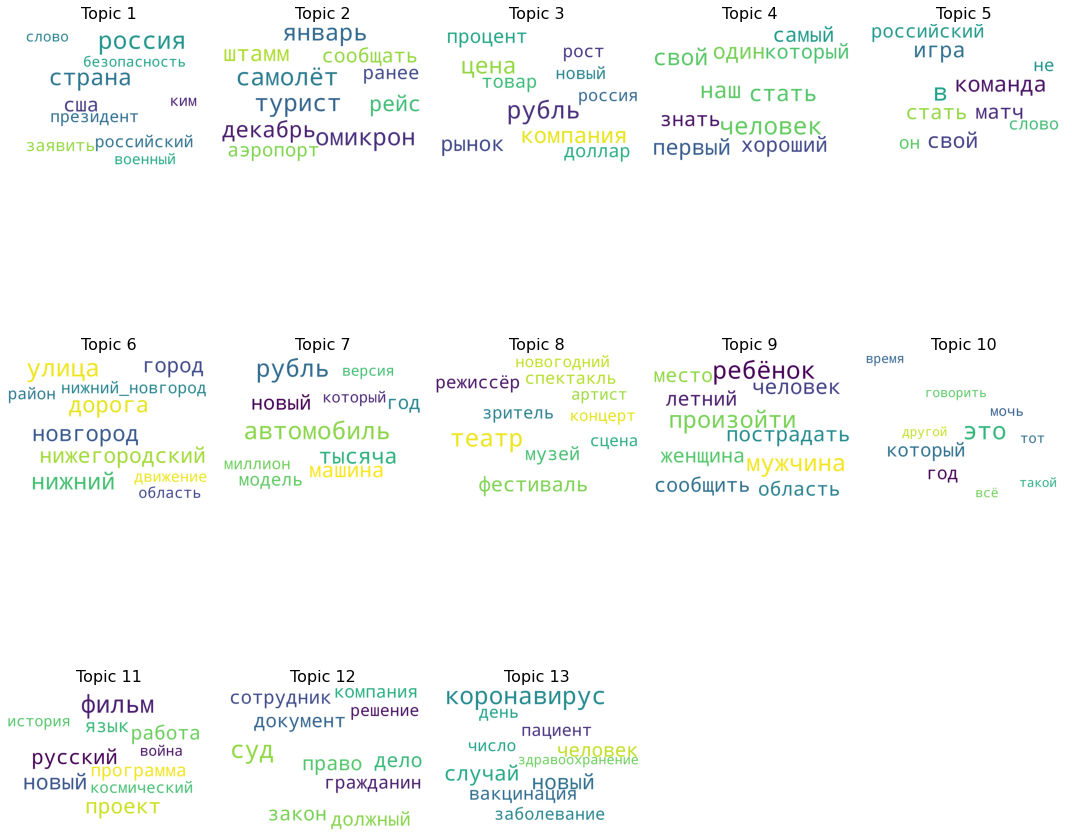

In [16]:
plot_worldclouds(model, 5, 3)

Here we can see the topics correspondig to the following known categories: 'auto' (topic 7), 'ekonomika' (topic 3), 'health' (topics 2, 13), 'incidents' (topic 9), 'kultura'/'media' (topics 8, 11), 'sport' (topic 5), 'transport' (topics 6 and 2), 'travel' (topic 2), 'world' (topic 1)

Unfortunately, the model hasn't managed to clearly define topics 4 and 10

Let's evaluate model's Coherence score

In [17]:
print_coherence(model=model, texts=texts, dictionary=dictionary)

Coherence Score: 0.556904535845379


Let's visualize the topics:

In [18]:
lda_visualization = gensimvis.prepare(model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_visualization)

We can see that there are overlapping topics. Most notably, topic 3 is completely included in topic 10 and topic 7 is almost completely included in topic 4. 

Let's try other numbers of topics: 

In [19]:
from gensim.models import LdaModel

# Set training parameters.
nums_topics = [9, 13, 17, 21, 25] # numbers of desired topics
chunksize = 2000 # number documents that are processed at a time in the training algorithm
passes = 40 # how often we train the model on the entire corpus (the same as epochs)
iterations = 400  # how often we repeat a particular loop over each document
eval_every = None  # Don't evaluate model perplexity, takes too much time

# Make a index to word dictionary.
id2word = dictionary.id2token

best_coherence = 0
for num_topics in nums_topics:
    print(f"Fitting for {num_topics} target topics")
    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every,
        random_state=43
    )
    
    coherence_score_lda = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_score_lda.get_coherence()
    if coherence_score > best_coherence:
        best_coherence = coherence_score
        best_lda_model = model
    print(f"Coherence score {coherence_score}")
    

Fitting for 9 target topics
Coherence score 0.5327301995794514
Fitting for 13 target topics
Coherence score 0.5265000444106218
Fitting for 17 target topics
Coherence score 0.5468181944087859
Fitting for 21 target topics
Coherence score 0.5527008724484621
Fitting for 25 target topics
Coherence score 0.5375521043940534


The best score was achieved for 21 target topics

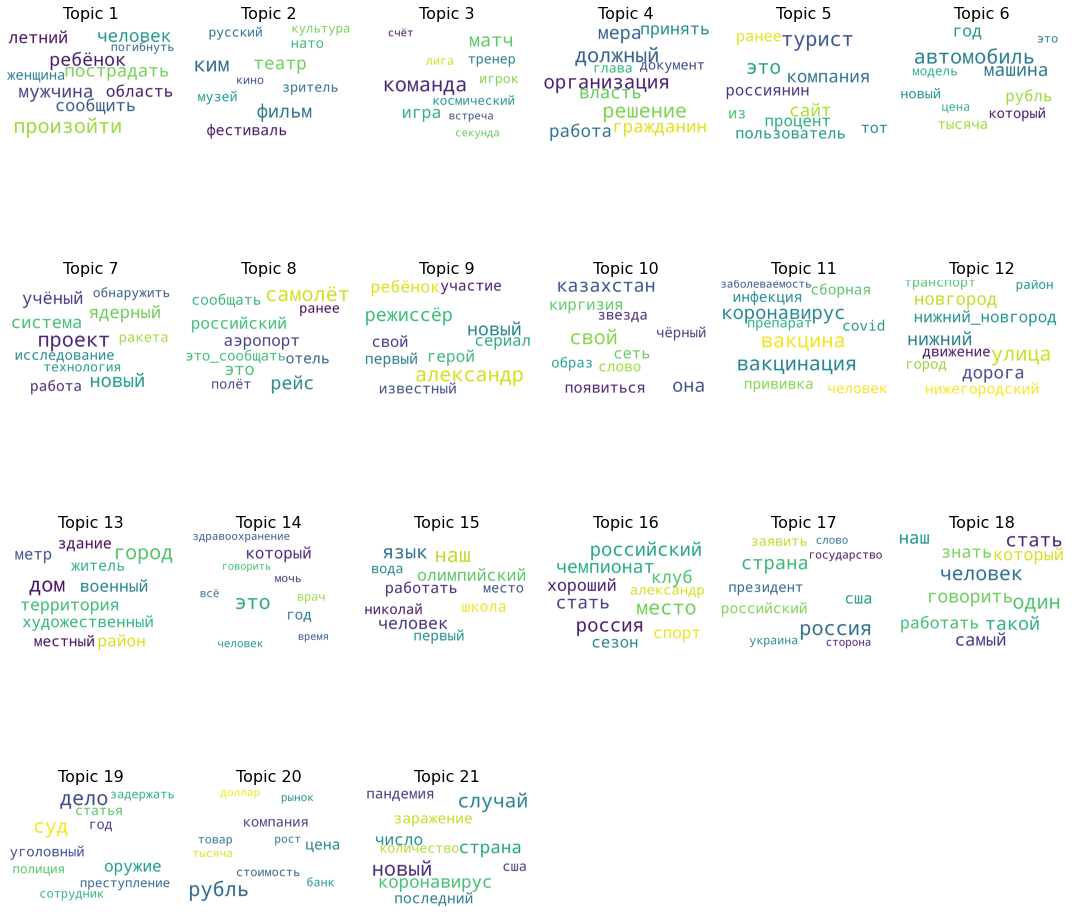

In [20]:
plot_worldclouds(best_lda_model, 6, 4)

In [21]:
lda_visualization = gensimvis.prepare(best_lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_visualization)

### Train LSI Model

In [22]:
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

Some helpful functions that will be used later:

In [23]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    #initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    #create Russian stop words list
    ru_stop = set(stopwords.words('russian'))
    ru_stop.update(['это', 'год', 'свой', 'который', 'ул', 'пгниу', 'мочь'])
    #Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    #list for tokenized documents in loop
    texts = []
    #loop through document list
    for i in doc_set:
        #clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        #remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in ru_stop]
        #stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        #add tokens to list
        texts.append(stemmed_tokens)
    return texts

def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    #Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    #Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    return dictionary, doc_term_matrix

def create_gensim_lsi_model(doc_clean, number_of_topics, words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSI model using gensim
    Output : return LSI model
    """
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    
    #generate LSI model
    lsimodel = LsiModel(
        doc_term_matrix, 
        num_topics = number_of_topics, 
        id2word = dictionary,
        chunksize = 2000,
        power_iters = 3,
    )#train model
    
    #print(lsimodel.print_topics(num_topics = number_of_topics, num_words = words))
    return lsimodel
    
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start, step):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSI topic models
              coherence_values : Coherence values corresponding to the LSI model with respective number of topics
    """
    coherence_values = list()
    model_list = []
    best_coherence = 0
    
    for num_topics in range(start, stop, step):
        #generate LSI model
        model = LsiModel(doc_term_matrix, num_topics = num_topics, id2word = dictionary)  #train model
        model_list.append(model)
        #calculate coherence_score
        coherencemodel = CoherenceModel(model = model, texts = doc_clean, dictionary = dictionary, coherence = 'c_v')
        coherence_score = coherencemodel.get_coherence()
        coherence_values.append(coherence_score)
        #choose best model
        if coherence_score > best_coherence:
            best_coherence = coherence_score
            best_lsi_model = model
            
    return coherence_values, model_list, best_coherence, best_lsi_model

Since we have 13 unique categories, let's see what result the model will give if we pass num_topics=13 as an argument.

In [24]:
#LSI Model
number_of_topics = 13
words = 10
document_list = df.text.tolist() #all texts
clean_text = preprocess_data(document_list)
dictionary, doc_term_matrix = prepare_corpus(clean_text)
model = create_gensim_lsi_model(clean_text, number_of_topics, words)
coherencemodel = CoherenceModel(model = model, texts = clean_text, dictionary = dictionary, coherence = 'c_v')
coherence_score = coherencemodel.get_coherence()
print("LSI coherence_score with 13 topics: ", coherence_score)

LSI coherence_score with 13 topics:  0.4443880937414401


In [25]:
topics = model.show_topics(formatted=False, num_topics=100)
for i in range (0, number_of_topics):
    lst = list()
    for item in topics[i][1]:
        lst.append(item[0])
    print("Topic", i)
    print(lst)

Topic 0
['человек', 'новый', 'россия', 'говорить', 'первый', 'рубль', 'стать', 'день', 'время', 'ребёнок']
Topic 1
['рубль', 'человек', 'автомобиль', 'цена', 'тысяча', 'машина', 'новый', 'врач', 'вакцина', 'модель']
Topic 2
['пермский', 'улица', 'вакцина', 'пострадать', 'университет', 'вакцинация', 'коронавирус', 'погибнуть', 'стрельба', 'врач']
Topic 3
['улица', 'площадь', 'пермский', 'движение', 'дом', 'нижний', 'маршрут', 'университет', 'новгород', 'рубль']
Topic 4
['автомобиль', 'рубль', 'фильм', 'тысяча', 'россия', 'человек', 'театр', 'машина', 'страна', 'улица']
Topic 5
['вакцина', 'ребёнок', 'россия', 'вакцинация', 'страна', 'коронавирус', 'врач', 'говорить', 'машина', 'новый']
Topic 6
['улица', 'область', 'водитель', 'нижегородский', 'пермский', 'нижний', 'цена', 'новгород', 'суд', 'фильм']
Topic 7
['вакцина', 'пациент', 'врач', 'вакцинация', 'автомобиль', 'машина', 'спутник', 'цена', 'прививка', 'человек']
Topic 8
['ребёнок', 'водитель', 'нижегородский', 'цена', 'техосмотр', '

Now let's plot the dependence of the coherence_score on the parameter num_topics.

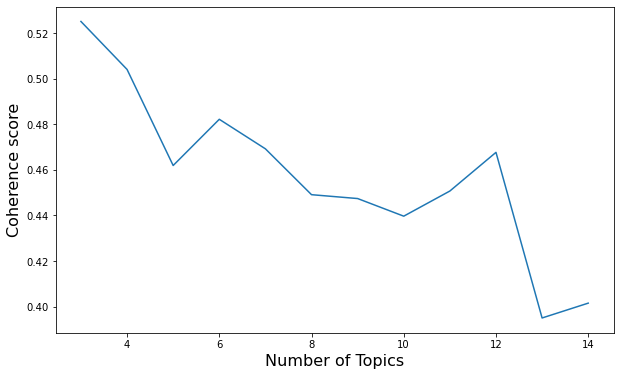

In [26]:
coherence_values, model_list, best_coherence, best_lsi_model = compute_coherence_values(
                                dictionary, doc_term_matrix, clean_text, stop=15, start=3, step=1)

num_topics = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
plt.figure(figsize=(10, 6))
plt.plot(num_topics, coherence_values)
plt.xlabel("Number of Topics", fontsize = 16)
plt.ylabel("Coherence score",  fontsize = 16)
plt.show()

As you can see from the chart, the best coherence score was achieved for 3 target topics.

In [37]:
print("Coherence score for 3 target topics: ", best_coherence)

Coherence score for 3 target topics:  0.5251580760018001


In [28]:
def plot_cloud(lst):
    unique_string=(" ").join(lst)
    wordcloud = WordCloud(background_color='white', width = 1000, height = 500).generate(unique_string)
    plt.figure(figsize=(4,4))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    plt.close()

Topic 0


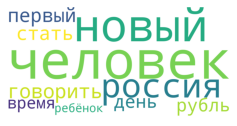

Topic 1


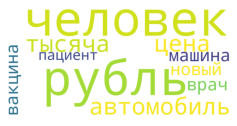

Topic 2


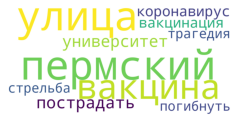

In [32]:
topics = best_lsi_model.show_topics(formatted=False, num_topics=100)
for i in range (0, 3):
    lst = list()
    for item in topics[i][1]:
        lst.append(item[0])
    print("Topic", i)
    plot_cloud(lst)

We also tried to train the PLSA model, but it only handles 1000 texts. When increasing the number of texts, we got an MemoryError :(

## HDP model

In [60]:
from gensim.models import HdpModel
from gensim.models.coherencemodel import CoherenceModel

In [61]:
chunksize = 4000 # number documents that are processed at a time in the training algorithm

# Make a index to word dictionary.
id2word = dictionary.id2token

model = HdpModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,

    random_state=42
)

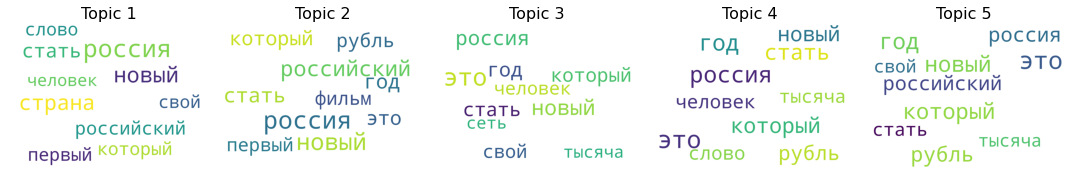

In [62]:
plot_worldclouds(model, 5, 1)

Resulted groups seem to be quite similar including the same words like "россия", "рубль" and etc.

In [63]:
coherencemodel = CoherenceModel(model = model, texts =texts, dictionary = dictionary, coherence = 'c_v')
coherence_score = coherencemodel.get_coherence()
print('HDP coherence score: ' , coherence_score)

HDP coherence score:  0.568002630974777


In [64]:
coherence_score

0.568002630974777

To conclude we outline the best coherence scores we achieved: </br>
1. LDA model - 0.55
2. LSI model - 0.52
3. HDP model - 0.56

Though the best value we achieved with the HDP model, the topics "clouds" seems strange and they do not differ much. (Also it may mean that the coherance metric is not always the best way to estimate the topic modeling)